In [1]:
import pandas as pd
import numpy as np
import itertools
import statistics
import scanpy as sc
import h5py 
import anndata
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import bottleneck as bn
import CococoNet_reader

In [2]:
def read_cococonet(file_location):
    import h5py
    net = h5py.File(file_location,'r')
    agg_dataset = net['agg'] 
    row_dataset = net['row']
    col_dataset = net['col']
    row_gene_list = []
    for gene in row_dataset:
        row_gene_list.append(gene.decode('UTF-8'))
    col_gene_list = []
    for gene in col_dataset: 
        col_gene_list.append(gene.decode('UTF-8'))
    net_df = pd.DataFrame(data = agg_dataset[:,:], index = row_gene_list, columns = col_gene_list)
    net.close()
    return net_df

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [4]:
def get_go_annotations_as_panda(species):
    import pandas as pd
    ## TAXA_ID to species_name 
    if type(species) == int:
        mapper = pd.read_csv('/home/passala/Gene_duplication_project/Generated_tables/Time_Savers/Species_name_resolver.csv')
        species = mapper['Common Name'].loc[mapper['Taxa ID'] == species].item()

    ## Get file_location 
    file_location = '/data/CoCoCoNet/gene2go/' + species + '_gene2go.csv'
    original_csv = pd.read_csv(file_location,sep = ' ')
    if len(original_csv) == 0:
        raise NameError('No Annotations for this Species :(')
    original_csv = original_csv.dropna()
    original_csv['Present'] = 1 
    matrixed_version = original_csv.pivot(index = 'NetworkIDs',columns = 'GO_term',values = 'Present')
    filled_matrixed_version = matrixed_version.fillna(value = 0)
    return filled_matrixed_version

In [5]:
def get_fc_sc_btw_two_species_with_gene_list(species_1,species_2,list_of_genes_in_species_1_as_panda):
    import pandas as pd
    import numpy as np
    #Convert Taxa to common names if NCBI taxa ID
    #Set up variable 
    fc_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')

    if type(species_1) == int:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_1].item()
    if type(species_2) == int:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_2].item()

    #Convert scientific name to common names if given scientific
    if ' ' in species_1:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_1].item()
    if ' ' in species_2:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_2].item()

    #Get Scientific Name
    scientific_1 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_1].item()
    scientific_2 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_2].item()

    if species_1 == species_2:
        raise NameError("Species are the Same, submit different species")
    
    # Get Path for Orthologs
    path_to_orthologs_mapped_pd = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_fc_scores.csv',index_col = 0)
    path_to_orthologs = path_to_orthologs_mapped_pd.loc[scientific_1,scientific_2]

    ortholog_map = pd.read_csv(path_to_orthologs)
    file_name = path_to_orthologs.split('/')[-1]
    file_name = file_name.split('_')
    if file_name[0] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp1_gene'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,on = 'sp1_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    if file_name[1] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp2_gene'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,on = 'sp2_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    # return fc_sc_map,species_name
    return fc_sc_map

In [6]:
def species_name_resolver(species_1,desired_type = 'common'):
    """Takes ambiguous form of species name and returns desired type 

    Args:
        species_1 ([str]): [Ambigious Species Name]
        desired_type (str, optional): [One of common, scientific, or taxa_id]. Defaults to 'common'.

    Returns:
        [str]: [Specified Species ID]
    """

    import pandas as pd
    import numpy as np

    # Assert 
    assert (desired_type in ['common','scientific','taxa_id']), 'Desired type should be common, scientific, or taxa_id'
   
    #Set up variable 
    fc_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')

    #Convert Taxa to common names if NCBI taxa ID
    if type(species_1) == int:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_1].item()

    #Convert scientific name to common names if given scientific
    if ' ' in species_1:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_1].item()

    #Get Scientific Name
    scientific_1 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_1].item()
    taxa_id_1 = fc_mapper['Taxa ID'].loc[fc_mapper['Common Name'] == species_1].item()

    if desired_type == 'common':
        return species_1
    elif desired_type =='scientific':
        return scientific_1
    elif desired_type == 'Taxa ID':
        return taxa_id_1


In [7]:
all_go_terms = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')
all_go_terms[['grape','arabidopsis','mustard','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']] = np.nan
all_go_terms

,Name,grape,arabidopsis,mustard,soybean,medicago,tomato,potato,rice,brome,sorghum,maize
GO:0000001,mitochondrion inheritance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000002,mitochondrial genome maintenance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000003,reproduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000006,high-affinity zinc transmembrane transporter a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000007,low-affinity zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:2001316,kojic acid metabolic process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
coconet_plants = ['grape','arabidopsis','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']
plant_combinations = itertools.permutations(coconet_plants,2)
plant_combinations = list(map(list,plant_combinations))
all_go_terms = all_go_terms.drop(columns = ['mustard'])

In [9]:
all_go_terms = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/go_terms_and_avg_fc_score_in_each_species.csv',index_col= 0)

In [10]:
all_go_terms = all_go_terms[['Name','arabidopsis']]
all_go_terms

,Name,arabidopsis
GO:0000001,mitochondrion inheritance,NaN
GO:0000002,mitochondrial genome maintenance,NaN
GO:0000003,reproduction,0.752135
GO:0000006,high-affinity zinc transmembrane transporter a...,NaN
GO:0000007,low-affinity zinc ion transmembrane transporte...,NaN
...,...,...
GO:0051184,NaN,0.752668
GO:0051194,NaN,0.815936
GO:0051182,NaN,0.746270
GO:0051185,NaN,0.751670


In [11]:
number_of_groups_for_each_go_term = all_go_terms.drop(columns = 'Name').count(axis = 1)
average_functional_conservation_for_each_term = all_go_terms.mean(axis = 1)

In [96]:
average_functional_conservation_for_each_term

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.752135
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.752668
GO:0051194    0.815936
GO:0051182    0.746270
GO:0051185    0.751670
GO:0018065         NaN
Length: 44290, dtype: float64

In [12]:
path_to_orthologs_mapped_pd = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_fc_scores.csv',index_col = 0)

In [13]:
all_correlations = pickle.load( open('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/correlation_for_single_cell_networks.p', 'rb'))

In [14]:
cococonet_map = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/All_CoCoCoNet_Paths.csv')
dict_of_results_from_single_cell = {}
all_go_group_egad_results = pd.DataFrame(index = all_go_terms.index)

for species in ['arabidopsis']:
    print(species)
    combos_that_start_with_species = []
    current_species_path_cococonet = cococonet_map['Path'].loc[cococonet_map['Common Name'] == species].item()
    for combo in plant_combinations:
        if combo[0] == species:
            combos_that_start_with_species.append(combo)
    current_species_annotations = get_go_annotations_as_panda(species)
    go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
    go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
    go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
    go_groups_for_egad = go_groups_with_counts.index.to_list()
    annotations_to_run_egad_on = current_species_annotations[go_groups_for_egad]
    current_scientific_name = species_name_resolver(species_1 = species,desired_type = 'scientific') 
    current_cococonet = read_cococonet(current_species_path_cococonet)
    egad_results = run_egad(go = annotations_to_run_egad_on, nw = current_cococonet,min_count =10, max_count = 2000 )
    all_go_group_egad_results = all_go_group_egad_results.merge(right = egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
    all_go_group_egad_results = all_go_group_egad_results.rename(columns = {'AUC':'{} AUC'.format(species),'P_Value':'{} P_Value'.format(species)})
    for number in np.arange(1,10):
        print(number)
        current_correlation_set = all_correlations[number]
        this_set_annotations = annotations_to_run_egad_on.loc[annotations_to_run_egad_on.index.isin(current_correlation_set.index)]
        current_set_egad_results = run_egad(go = this_set_annotations, nw = current_correlation_set,min_count =5, max_count = 2000 )
        single_cell_egad_results = pd.DataFrame(index = all_go_terms.index)
        single_cell_egad_results = single_cell_egad_results.merge(right = current_set_egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
        single_cell_egad_results = single_cell_egad_results.rename(columns = {'AUC':'{} AUC'.format(species),'P_Value':'{} P_Value'.format(species)})
        dict_of_results_from_single_cell[number] = single_cell_egad_results




arabidopsis


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


1


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


2


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


3


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


4


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


5


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


6


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


7


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


8


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


9


/tmp/ipykernel_2240842/4237006214.py:106: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [15]:
all_go_group_egad_results

,arabidopsis AUC,arabidopsis P_Value
GO:0000001,NaN,NaN
GO:0000002,NaN,NaN
GO:0000003,0.637415,7.013306e-77
GO:0000006,NaN,NaN
GO:0000007,NaN,NaN
...,...,...
GO:0051184,0.418488,1.177666e-01
GO:0051194,0.739692,2.103215e-03
GO:0051182,0.517158,3.518054e-01
GO:0051185,0.542371,2.974942e-01


In [16]:
dict_of_results_from_single_cell[1]['arabidopsis AUC']

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.581052
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.549690
GO:0051194         NaN
GO:0051182    0.580840
GO:0051185    0.485842
GO:0018065         NaN
Name: arabidopsis AUC, Length: 44290, dtype: float64

In [17]:
all_egad_results = all_go_group_egad_results[['arabidopsis AUC']]
egad_means = all_egad_results.mean(axis = 1)
egad_means

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.637415
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.418488
GO:0051194    0.739692
GO:0051182    0.517158
GO:0051185    0.542371
GO:0018065         NaN
Length: 44290, dtype: float64

In [18]:
groups_with_values = pd.concat([average_functional_conservation_for_each_term,egad_means],axis = 1)
groups_with_values = groups_with_values.rename(columns = {0:'Avg FC',1:'Avg EGAD'})
groups_with_values = groups_with_values.merge(right = all_go_terms['Name'],left_index = True,right_index = True)

In [19]:
dict_of_results_from_single_cell[3]['arabidopsis AUC']

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.546741
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.642266
GO:0051194         NaN
GO:0051182    0.574950
GO:0051185    0.608875
GO:0018065         NaN
Name: arabidopsis AUC, Length: 44290, dtype: float64

In [20]:
for number in np.arange(1,10):
    current_egad_result = dict_of_results_from_single_cell[number]['arabidopsis AUC']
    groups_with_values['Single Cell Group '+ str(number)] = current_egad_result
    

In [21]:
groups_with_values

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9
GO:0000001,NaN,NaN,mitochondrion inheritance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000002,NaN,NaN,mitochondrial genome maintenance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000003,0.752135,0.637415,reproduction,0.581052,0.567796,0.546741,0.570845,0.576263,0.610293,0.570334,0.515310,0.539710
GO:0000006,NaN,NaN,high-affinity zinc transmembrane transporter a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000007,NaN,NaN,low-affinity zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0051184,0.752668,0.418488,NaN,0.549690,0.529827,0.642266,0.718846,0.652839,0.643878,0.638522,0.595774,0.542258
GO:0051194,0.815936,0.739692,NaN,NaN,NaN,NaN,NaN,0.713054,NaN,0.724273,NaN,NaN
GO:0051182,0.746270,0.517158,NaN,0.580840,0.504770,0.574950,0.747122,0.546426,0.643644,0.719881,0.618376,0.490254
GO:0051185,0.751670,0.542371,NaN,0.485842,0.408561,0.608875,0.781803,0.492967,0.610027,0.714338,0.689477,0.534127


In [22]:
arabidopsis_all_group_data = groups_with_values.dropna(subset = ['Avg FC','Avg EGAD'])
arabidopsis_all_group_data

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9
GO:0000003,0.752135,0.637415,reproduction,0.581052,0.567796,0.546741,0.570845,0.576263,0.610293,0.570334,0.515310,0.539710
GO:0000018,0.760489,0.718649,regulation of DNA recombination,0.738206,0.551079,0.475856,0.545338,0.503453,0.719218,0.732806,0.545516,0.850624
GO:0000027,0.937799,0.912810,ribosomal large subunit assembly,0.895737,0.798247,0.850754,0.903814,0.792097,0.900878,0.855558,0.736873,0.850691
GO:0000028,0.946437,0.856894,ribosomal small subunit assembly,0.899352,0.862396,0.842174,0.900567,0.900673,0.921395,0.865187,0.726230,0.855060
GO:0000030,0.716687,0.688263,mannosyltransferase activity,0.754445,0.729323,0.638281,0.541118,0.592709,0.730357,0.670838,0.443551,0.635846
...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0051193,0.769318,0.656521,NaN,0.610859,0.531566,0.505157,0.421554,0.626168,0.501049,0.560783,0.585340,0.570503
GO:0051184,0.752668,0.418488,NaN,0.549690,0.529827,0.642266,0.718846,0.652839,0.643878,0.638522,0.595774,0.542258
GO:0051194,0.815936,0.739692,NaN,NaN,NaN,NaN,NaN,0.713054,NaN,0.724273,NaN,NaN
GO:0051182,0.746270,0.517158,NaN,0.580840,0.504770,0.574950,0.747122,0.546426,0.643644,0.719881,0.618376,0.490254


In [23]:
full_annotated_group_list = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/gm_version_all_annotated_groups.csv',encoding = 'cp1252',index_col= 0)
full_annotated_group_list

,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation,Notes
GO:0000003,0.740324,0.634227,reproduction,10,None,NaN
GO:0000018,0.766573,0.798689,regulation of DNA recombination,8,None,NaN
GO:0000027,0.923946,0.869159,ribosomal large subunit assembly,9,Ribosomal,NaN
GO:0000028,0.951180,0.875073,ribosomal small subunit assembly,9,Ribosomal,NaN
GO:0000030,0.714718,0.642678,mannosyltransferase activity,8,None,Critical function in eukaryotes
...,...,...,...,...,...,...
GO:2001020,0.821085,0.761272,regulation of response to DNA damage stimulus,9,None,NaN
GO:2001070,0.720227,0.869219,starch binding,7,None,NaN
GO:2001141,0.722697,0.673483,regulation of RNA biosynthetic process,6,None,NaN
GO:2001251,0.778751,0.805120,negative regulation of chromosome organization,9,None,NaN


In [24]:
#slimmed_to_original_list = arabidopsis_all_group_data.loc[arabidopsis_all_group_data.index.isin(full_annotated_group_list.index)]
slimmed_to_original_list = arabidopsis_all_group_data.merge( right = full_annotated_group_list[['Annotation']], right_index=True,left_index= True)
slimmed_to_original_list

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9,Annotation
GO:0000003,0.752135,0.637415,reproduction,0.581052,0.567796,0.546741,0.570845,0.576263,0.610293,0.570334,0.515310,0.539710,None
GO:0000018,0.760489,0.718649,regulation of DNA recombination,0.738206,0.551079,0.475856,0.545338,0.503453,0.719218,0.732806,0.545516,0.850624,None
GO:0000027,0.937799,0.912810,ribosomal large subunit assembly,0.895737,0.798247,0.850754,0.903814,0.792097,0.900878,0.855558,0.736873,0.850691,Ribosomal
GO:0000028,0.946437,0.856894,ribosomal small subunit assembly,0.899352,0.862396,0.842174,0.900567,0.900673,0.921395,0.865187,0.726230,0.855060,Ribosomal
GO:0000030,0.716687,0.688263,mannosyltransferase activity,0.754445,0.729323,0.638281,0.541118,0.592709,0.730357,0.670838,0.443551,0.635846,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0051181,0.703080,0.595093,NaN,0.538030,0.480960,0.571301,0.623093,0.487892,0.659829,0.450680,0.586622,0.598454,None
GO:0051193,0.769318,0.656521,NaN,0.610859,0.531566,0.505157,0.421554,0.626168,0.501049,0.560783,0.585340,0.570503,None
GO:0051184,0.752668,0.418488,NaN,0.549690,0.529827,0.642266,0.718846,0.652839,0.643878,0.638522,0.595774,0.542258,None
GO:0051182,0.746270,0.517158,NaN,0.580840,0.504770,0.574950,0.747122,0.546426,0.643644,0.719881,0.618376,0.490254,None


In [25]:
slimmed_to_original_list.loc[(slimmed_to_original_list['Annotation']=='Secondary Metabolism')& (slimmed_to_original_list['Avg EGAD']<.6)]

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9,Annotation
GO:0019438,0.726738,0.575262,aromatic compound biosynthetic process,0.557222,0.561243,0.549231,0.586914,0.588491,0.571115,0.542788,0.541989,0.526491,Secondary Metabolism
GO:0019439,0.749245,0.571081,aromatic compound catabolic process,0.505678,0.524394,0.552417,0.584456,0.544353,0.576479,0.542508,0.557862,0.537172,Secondary Metabolism


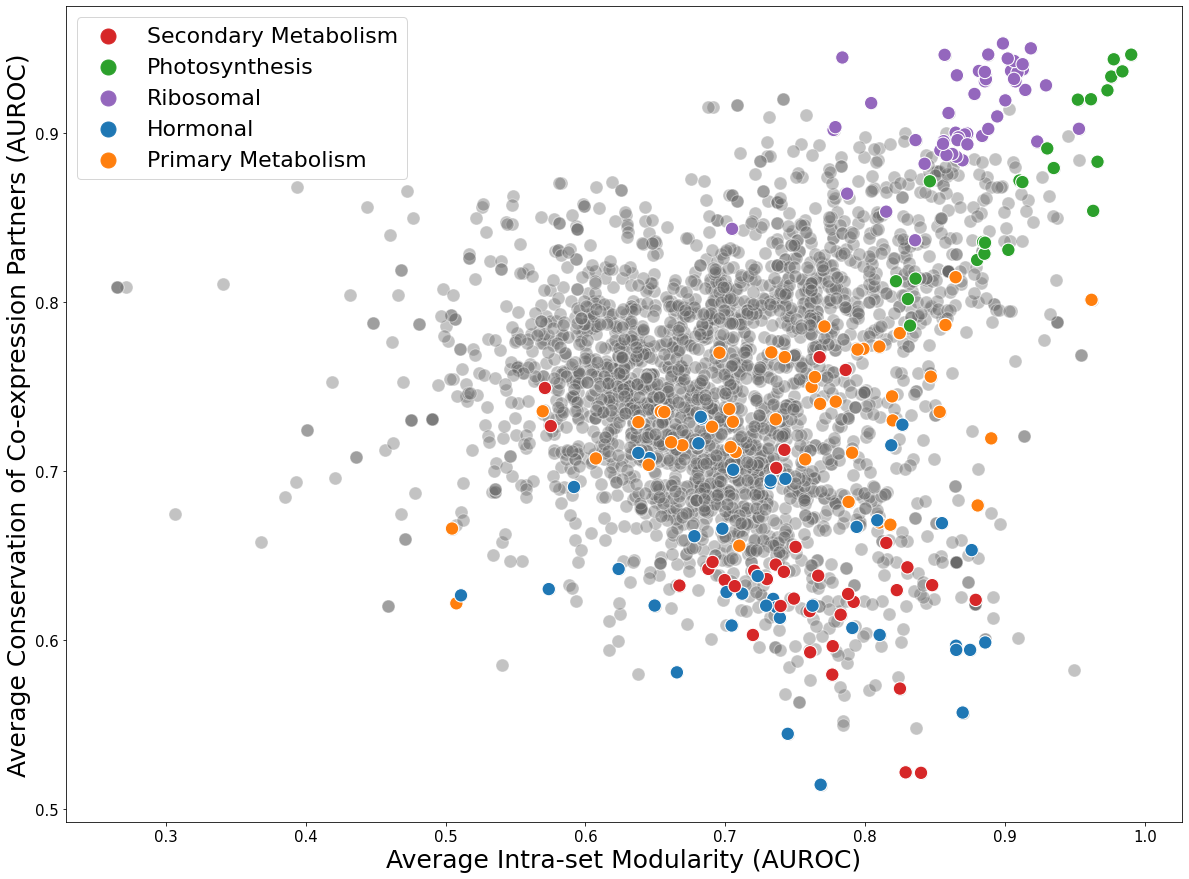

In [26]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = slimmed_to_original_list,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation'] != 'None'], x = 'Avg EGAD',y = 'Avg FC',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal','Primary Metabolism'], palette = ['tab:red','tab:green','tab:purple','tab:blue', 'tab:orange'],)

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [27]:
ident_line = np.linspace(0,2,num =200)

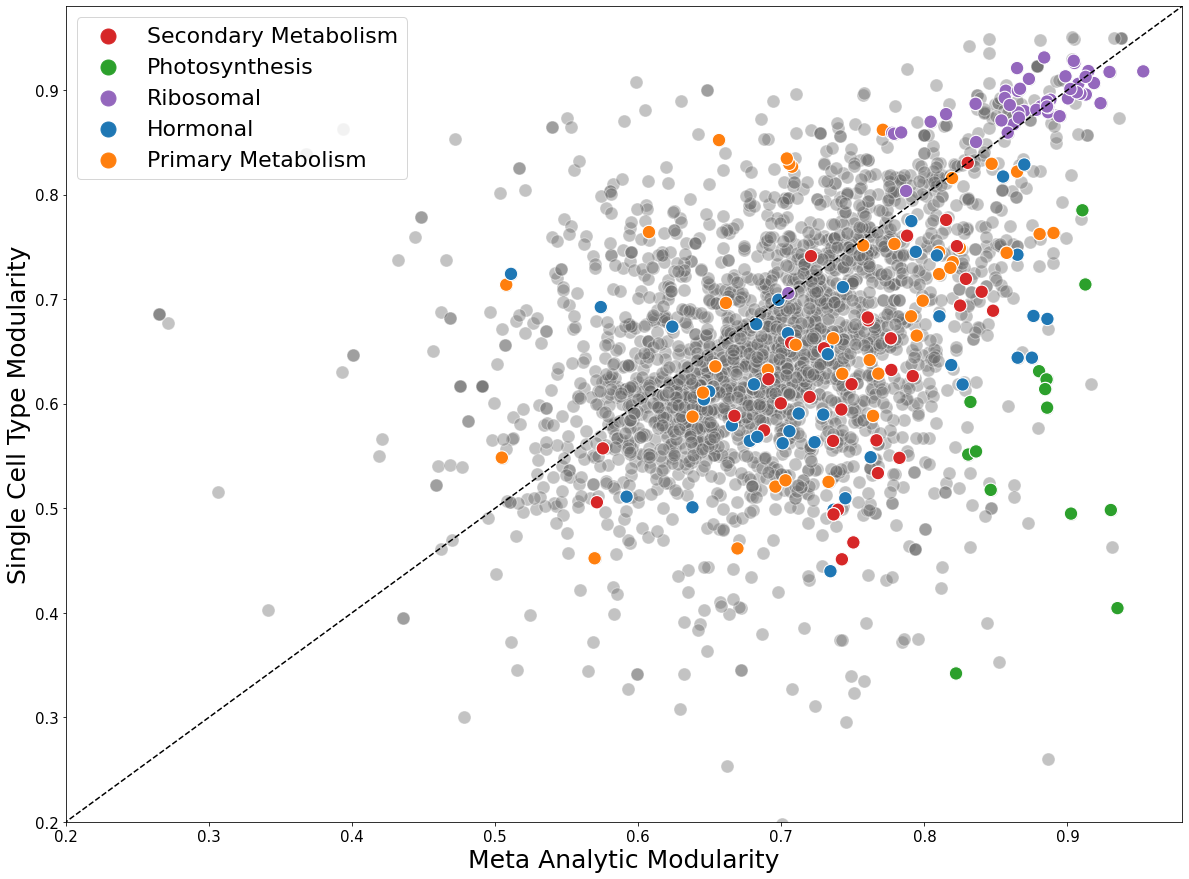

In [28]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = slimmed_to_original_list,y = 'Single Cell Group 1',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation'] != 'None'], x = 'Avg EGAD',y = 'Single Cell Group 1',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal', 'Primary Metabolism'], palette = ['tab:red','tab:green','tab:purple','tab:blue', 'tab:orange'],)
plt.plot(ident_line,ident_line,'--k')
plt.xlim(.2,.98)
plt.ylim(.2,.98)
plt.ylabel("Single Cell Type Modularity", fontsize = 25)
plt.xlabel("Meta Analytic Modularity", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [29]:
list_of_titles = ['Columella','Trichoblasts','Xylem','Phloem 1','Cortex','QC/Stem Cells','Endodermis 1','Phloem 2','Endodermis 2']

In [30]:
list_of_columns = []
for number in np.arange(1,10):
    current_string = 'Single Cell Group ' + str(number)
    list_of_columns.append(current_string)
list_of_columns

['Single Cell Group 1',
 'Single Cell Group 2',
 'Single Cell Group 3',
 'Single Cell Group 4',
 'Single Cell Group 5',
 'Single Cell Group 6',
 'Single Cell Group 7',
 'Single Cell Group 8',
 'Single Cell Group 9']

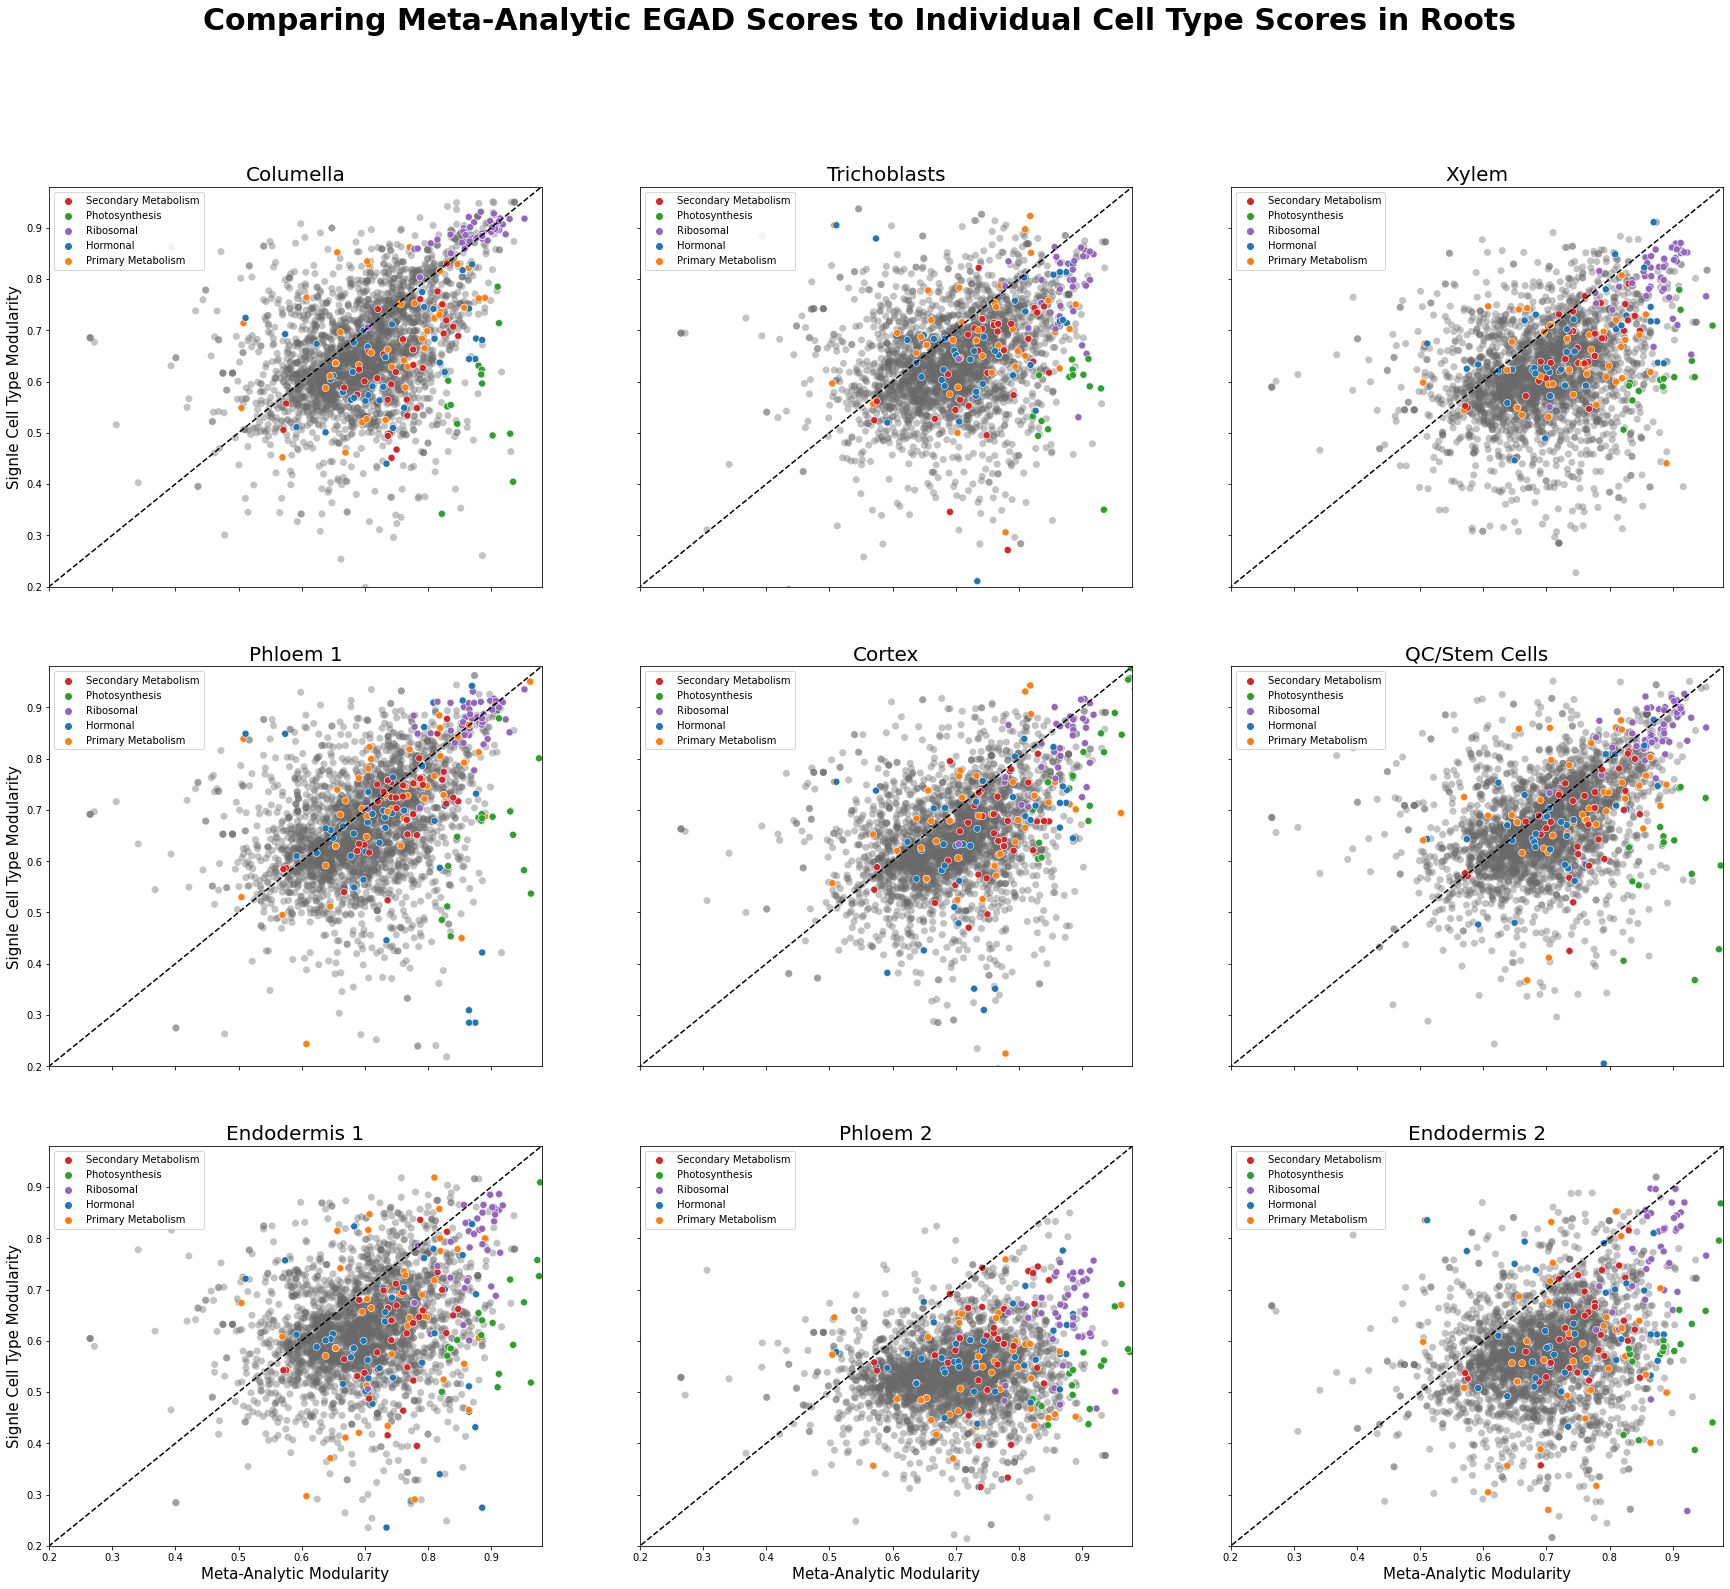

In [31]:
fig, axs = plt.subplots(3,3,sharex = True, sharey = True,figsize = (30,25))
fig.suptitle('Comparing Meta-Analytic EGAD Scores to Individual Cell Type Scores in Roots',fontsize = 30,fontweight = 'bold')
for (ax_number,value,titular) in zip(axs.flat,list_of_columns,list_of_titles): 
    sns.scatterplot(ax = ax_number,data = slimmed_to_original_list,y = value,x = 'Avg EGAD',s = 50,color = 'dimgray', alpha = .4, edgecolor = 'none')
    sns.scatterplot(ax = ax_number,data = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation'] != 'None'], x = 'Avg EGAD',y = value,s = 50, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal','Primary Metabolism'], palette = ['tab:red','tab:green','tab:purple','tab:blue','tab:orange'],)
    sns.lineplot(x =ident_line,y =ident_line,color ='k',ls = '--',ax = ax_number)
    plt.xlim(.2,.98)
    plt.ylim(.2,.98)
    ax_number.set_xlabel('Meta-Analytic Modularity',fontsize = 15)
    ax_number.set_ylabel('Signle Cell Type Modularity',fontsize = 15)
    ax_number.set_title(titular, fontsize = 20)
    #ax_number.plot(current_mean,current_var)

In [32]:
color_list = ['tab:purple','tab:blue','tab:red','tab:green']


In [33]:
# # libraries & dataset
# import seaborn as sns
# import matplotlib.pyplot as plt
# # set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
# sns.set(style="darkgrid")
# df = sns.load_dataset('iris')

# my_pal = {species: "r" if species == "versicolor" else "b" for species in df.species.unique()}
# sns.boxplot( x=df["species"], y=df["sepal_length"], palette=my_pal)
# plt.show()

In [34]:
tester_pallete = {'Avg EGAD':'tab:gray','Single Cell Group 1':['tab:red','tab:green','tab:purple','tab:blue']}

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

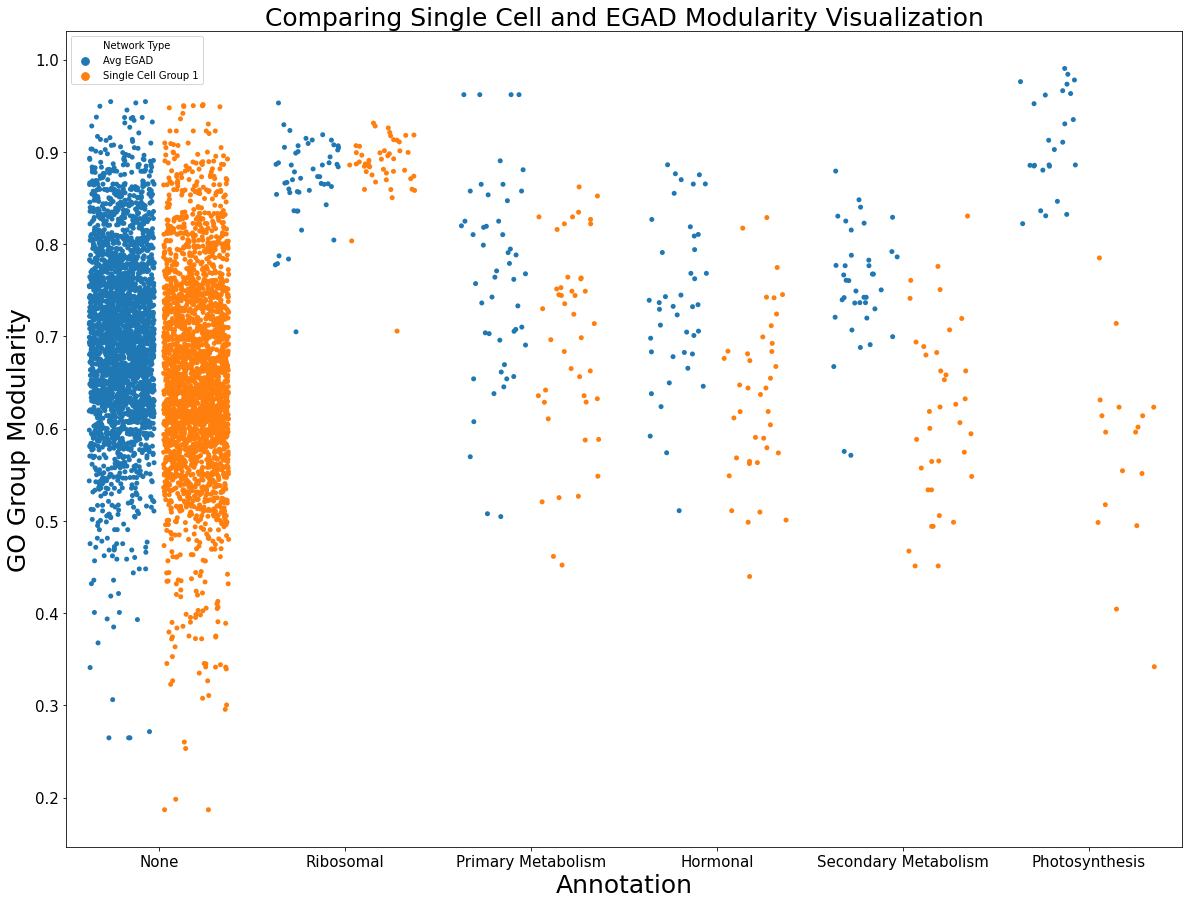

In [35]:
fig, ax = plt.subplots(figsize = (20,15))
tidy_test = pd.melt(slimmed_to_original_list, id_vars =['Name','Annotation'], value_vars = ['Avg EGAD','Single Cell Group 1'], ignore_index = False, var_name = 'Network Type', value_name = 'GO Group Modularity')
sns.stripplot(data = tidy_test, x = 'Annotation',y = 'GO Group Modularity',hue = 'Network Type',dodge = True, jitter = .35,)
plt.ylabel("GO Group Modularity", fontsize = 25)
plt.xlabel("Annotation", fontsize = 25)
plt.title("Comparing Single Cell and EGAD Modularity Visualization", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [36]:
N=20
# dummy dataset
data = np.random.normal(size=(N,))
df = pd.DataFrame({'condition 1': data,
                   'condition 2': data+1,
                   'condition 3': data,
                   'condition 4': data-1})

In [37]:
slimmed_to_original_list

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9,Annotation
GO:0000003,0.752135,0.637415,reproduction,0.581052,0.567796,0.546741,0.570845,0.576263,0.610293,0.570334,0.515310,0.539710,None
GO:0000018,0.760489,0.718649,regulation of DNA recombination,0.738206,0.551079,0.475856,0.545338,0.503453,0.719218,0.732806,0.545516,0.850624,None
GO:0000027,0.937799,0.912810,ribosomal large subunit assembly,0.895737,0.798247,0.850754,0.903814,0.792097,0.900878,0.855558,0.736873,0.850691,Ribosomal
GO:0000028,0.946437,0.856894,ribosomal small subunit assembly,0.899352,0.862396,0.842174,0.900567,0.900673,0.921395,0.865187,0.726230,0.855060,Ribosomal
GO:0000030,0.716687,0.688263,mannosyltransferase activity,0.754445,0.729323,0.638281,0.541118,0.592709,0.730357,0.670838,0.443551,0.635846,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0051181,0.703080,0.595093,NaN,0.538030,0.480960,0.571301,0.623093,0.487892,0.659829,0.450680,0.586622,0.598454,None
GO:0051193,0.769318,0.656521,NaN,0.610859,0.531566,0.505157,0.421554,0.626168,0.501049,0.560783,0.585340,0.570503,None
GO:0051184,0.752668,0.418488,NaN,0.549690,0.529827,0.642266,0.718846,0.652839,0.643878,0.638522,0.595774,0.542258,None
GO:0051182,0.746270,0.517158,NaN,0.580840,0.504770,0.574950,0.747122,0.546426,0.643644,0.719881,0.618376,0.490254,None


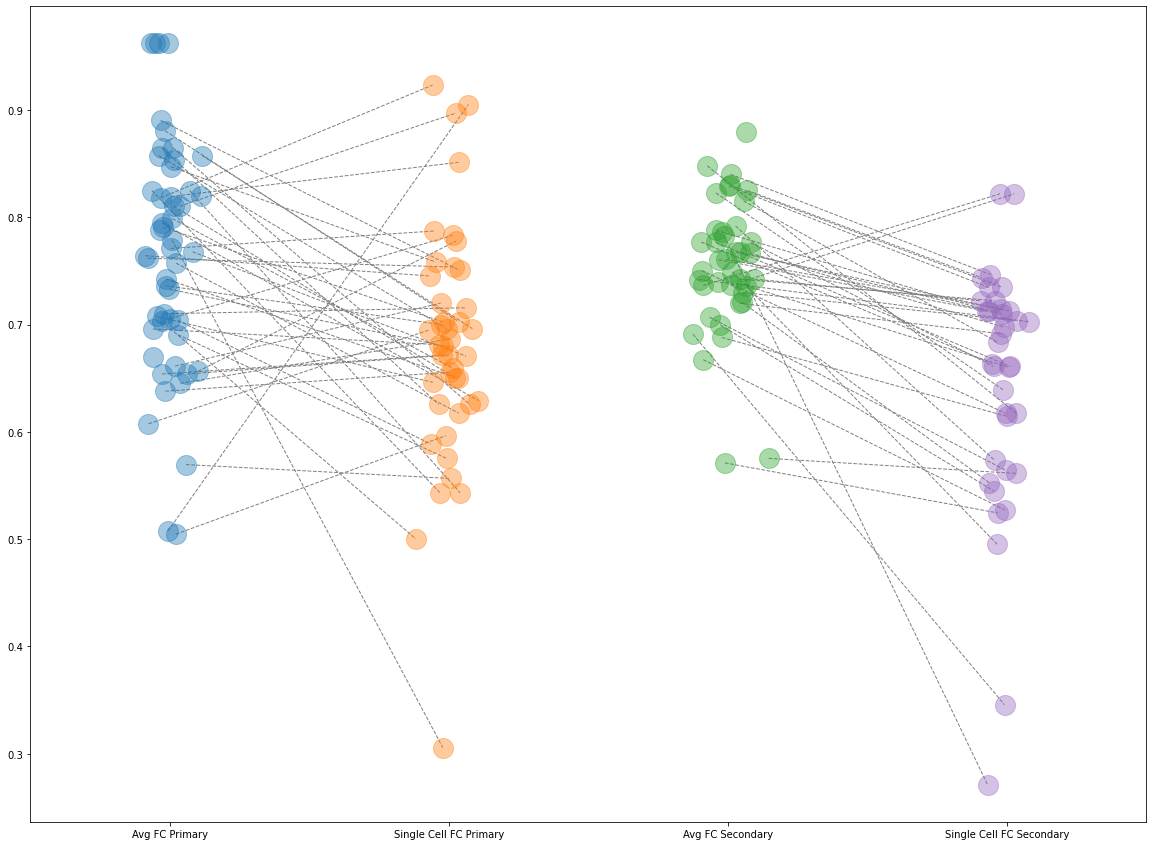

In [95]:
tester_slimmed_to_secondary = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation']== 'Secondary Metabolism']
tester_slimmed_to_primary  = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation']== 'Primary Metabolism']
tester_dataset_secondary = tester_slimmed_to_secondary[['Avg EGAD','Single Cell Group 2']]
tester_dataset_primary = tester_slimmed_to_primary[['Avg EGAD','Single Cell Group 2']]

tester_dataset_secondary = tester_dataset_secondary.reset_index(drop = True)
tester_dataset_primary = tester_dataset_primary.reset_index(drop = True)
tester_dataset = tester_dataset_primary.merge(right = tester_dataset_secondary, how = 'outer',right_index = True, left_index = True)
tester_dataset.columns = ['Avg FC Primary', 'Single Cell FC Primary','Avg FC Secondary','Single Cell FC Secondary']
tester_dataset

jitter = .05
df_x_jitter = pd.DataFrame(np.random.normal(loc = 0, scale = jitter, size = tester_dataset.values.shape), columns = tester_dataset.columns)
df_x_jitter += np.arange(len(tester_dataset.columns))
df_x_jitter

fig, ax = plt.subplots(figsize = (20,15))
color_list = ['tab:blue','tab:orange','tab:green','tab:purple']

for (col,cur_color) in zip(tester_dataset,color_list):
    ax.plot(df_x_jitter[col],tester_dataset[col], 'o',alpha = .4, zorder = 1, ms = 20, mew = 1, color = cur_color)

ax.set_xticks (range(len(tester_dataset.columns)))
ax.set_xticklabels(tester_dataset.columns)
ax.set_xlim(-0.5,len(tester_dataset.columns)-0.5)

for idx in tester_dataset.index:
    ax.plot(df_x_jitter.loc[idx,['Avg FC Primary','Single Cell FC Primary']],tester_dataset.loc[idx,['Avg FC Primary','Single Cell FC Primary']], color = 'gray',linewidth = 1, linestyle = '--', zorder=-1)
    ax.plot(df_x_jitter.loc[idx,['Avg FC Secondary','Single Cell FC Secondary']],tester_dataset.loc[idx,['Avg FC Secondary','Single Cell FC Secondary']], color = 'gray',linewidth =1, linestyle = '--', zorder=-1)



In [87]:
slimmed_to_original_list.loc[slimmed_to_original_list['Annotation']=='Primary Metabolism'].sort_values(by = 'Single Cell Group 2', ascending = False)

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9,Annotation
GO:0016760,0.668320,0.818116,cellulose synthase (UDP-forming) activity,0.729930,0.923131,0.667426,0.884478,0.942954,0.875023,0.857438,0.593884,0.804321,Primary Metabolism
GO:0004805,0.621784,0.507717,trehalose-phosphatase activity,0.713804,0.904945,0.674086,0.838690,0.754933,0.643023,0.721171,0.645570,0.835338,Primary Metabolism
GO:0009833,0.669622,0.810220,plant-type primary cell wall biogenesis,0.745144,0.897115,0.720301,0.910861,0.931097,0.860827,0.918699,0.593432,0.852644,Primary Metabolism
GO:0072350,0.744271,0.819304,tricarboxylic acid metabolic process,0.815836,0.851162,0.807272,0.859962,0.887038,0.856899,0.800234,0.467345,0.624881,Primary Metabolism
GO:0006526,0.785659,0.770930,arginine biosynthetic process,0.861982,0.787159,0.662188,0.818133,0.614369,0.830222,0.644894,0.506468,0.504520,Primary Metabolism
GO:0009225,0.729262,0.705464,nucleotide-sugar metabolic process,0.829461,0.783124,0.709277,0.780951,0.765417,0.860129,0.816395,0.635188,0.716750,Primary Metabolism
GO:0009226,0.735022,0.656429,nucleotide-sugar biosynthetic process,0.852114,0.777757,0.740765,0.739611,0.738124,0.858230,0.814688,0.607213,0.686690,Primary Metabolism
GO:0047262,0.755944,0.847001,polygalacturonate 4-alpha-galacturonosyltransf...,0.829440,0.758264,0.690590,0.842860,0.714746,0.747520,0.778913,0.449501,0.638789,Primary Metabolism
GO:0006544,0.749875,0.761755,glycine metabolic process,0.641733,0.753592,0.628838,0.683720,0.590741,0.679990,0.735375,0.559698,0.448206,Primary Metabolism
GO:0016774,0.719415,0.890228,"phosphotransferase activity, carboxyl group as...",0.763287,0.750484,0.440394,0.687497,0.701116,0.749338,0.799907,0.451935,0.498899,Primary Metabolism


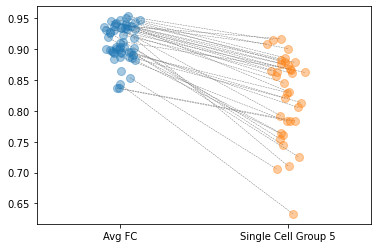

In [40]:
tester_slimmed_to_secondary = slimmed_to_original_list.loc[slimmed_to_original_list['Annotation']== 'Ribosomal']
tester_dataset = tester_slimmed_to_secondary[['Avg FC','Single Cell Group 5']]
tester_dataset = tester_dataset.reset_index(drop = True)
jitter = .05
df_x_jitter = pd.DataFrame(np.random.normal(loc = 0, scale = jitter, size = tester_dataset.values.shape), columns = tester_dataset.columns)
df_x_jitter += np.arange(len(tester_dataset.columns))
df_x_jitter

fig,ax = plt.subplots()

for col in tester_dataset:
    ax.plot(df_x_jitter[col],tester_dataset[col], 'o',alpha = .40, zorder = 1, ms = 8, mew = 1)

ax.set_xticks (range(len(tester_dataset.columns)))
ax.set_xticklabels(tester_dataset.columns)
ax.set_xlim(-0.5,len(tester_dataset.columns)-0.5)

for idx in tester_dataset.index:
    ax.plot(df_x_jitter.loc[idx,['Avg FC','Single Cell Group 5']],tester_dataset.loc[idx,['Avg FC','Single Cell Group 5']], color = 'gray',linewidth = 0.5, linestyle = '--', zorder=-1)


In [41]:
slimmed_to_original_list.loc[slimmed_to_original_list['Annotation'] == "Hormonal"].sort_values(by = 'Single Cell Group 4', ascending = False)

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9,Annotation
GO:1900750,0.557140,0.869796,oligopeptide binding,0.828734,0.720111,0.911053,0.942079,0.745904,0.875827,0.827936,0.776260,0.810101,Hormonal
GO:0080161,0.669256,0.854986,auxin transmembrane transporter activity,0.817281,0.808517,0.822520,0.913573,0.822794,0.825716,0.767273,0.619941,0.698096,Hormonal
GO:0010315,0.670939,0.808710,auxin efflux,0.741784,0.803006,0.848404,0.909297,0.838837,0.808440,0.779324,0.551829,0.700320,Hormonal
GO:0010329,0.667033,0.793977,auxin efflux transmembrane transporter activity,0.745251,0.757660,0.779989,0.861662,0.804299,0.808841,0.761669,0.568319,0.693877,Hormonal
GO:0005992,0.626505,0.511052,trehalose biosynthetic process,0.724149,0.904945,0.674086,0.848580,0.754933,0.643023,0.721171,0.578170,0.835338,Hormonal
GO:0005991,0.630213,0.573810,trehalose metabolic process,0.692417,0.879103,0.624883,0.848580,0.737635,0.643023,0.757049,0.549333,0.775047,Hormonal
GO:0010268,0.607198,0.790862,brassinosteroid homeostasis,0.774612,0.612101,0.682471,0.785605,0.724996,0.205073,0.557423,0.672742,0.790312,Hormonal
GO:0080030,0.544559,0.744708,methyl indole-3-acetate esterase activity,0.509506,0.687304,0.658876,0.763572,0.309578,0.561651,0.528139,0.600083,0.613493,Hormonal
GO:0042562,0.700853,0.705643,hormone binding,0.573627,0.521909,0.571855,0.734859,0.561673,0.622932,0.526763,0.548794,0.550638,Hormonal
GO:0009695,0.653307,0.876218,jasmonic acid biosynthetic process,0.683911,0.713828,0.636750,0.731680,0.739086,0.746707,0.690906,0.630954,0.561027,Hormonal


(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

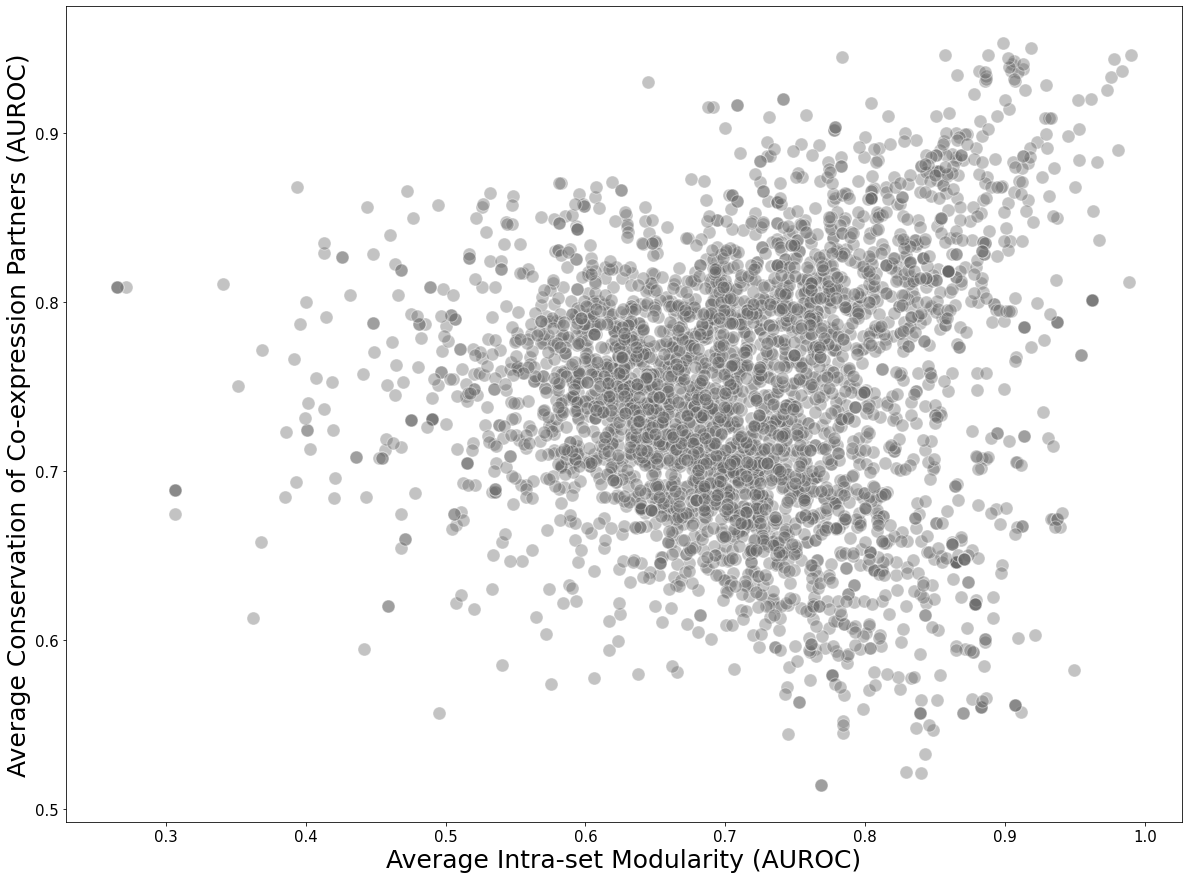

In [42]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = arabidopsis_all_group_data,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [43]:
arabidopsis_cococonet = CococoNet_reader.read_cococonet('arabidopsis')
arabidopsis_cococonet

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130,ATCG01180,ATCG01210,ATCG01310
AT1G01020,1.000000,0.676041,0.885107,0.916603,0.167027,0.625596,0.801175,0.866369,0.954286,0.715750,...,0.111731,0.193853,0.261697,0.299060,0.321617,0.287853,0.559907,0.017205,0.011806,0.091015
AT1G01030,0.676041,1.000000,0.707718,0.515532,0.420354,0.292083,0.687003,0.626281,0.483536,0.570675,...,0.245167,0.215414,0.255414,0.306986,0.308402,0.270118,0.463394,0.083490,0.059014,0.108780
AT1G01040,0.885107,0.707718,1.000000,0.836387,0.545101,0.701558,0.656258,0.857046,0.657204,0.650843,...,0.155183,0.230038,0.149740,0.334558,0.287951,0.186425,0.219380,0.032348,0.018332,0.057761
AT1G01050,0.916603,0.515532,0.836387,1.000000,0.562112,0.726964,0.837948,0.928252,0.952045,0.640223,...,0.089440,0.177388,0.164935,0.236661,0.251851,0.213062,0.412583,0.046082,0.029016,0.086736
AT1G01060,0.167027,0.420354,0.545101,0.562112,1.000000,0.327202,0.242215,0.304953,0.217415,0.077569,...,0.082518,0.125455,0.103488,0.187982,0.195059,0.125488,0.212731,0.061676,0.057518,0.044208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01120,0.287853,0.270118,0.186425,0.213062,0.125488,0.083681,0.364707,0.333718,0.237716,0.149145,...,0.858389,0.905572,0.926062,0.941864,0.954421,1.000000,0.969018,0.450607,0.357960,0.410586
ATCG01130,0.559907,0.463394,0.219380,0.412583,0.212731,0.077222,0.625678,0.496059,0.428496,0.226147,...,0.881835,0.936241,0.946935,0.958553,0.960399,0.969018,1.000000,0.467233,0.412343,0.483002
ATCG01180,0.017205,0.083490,0.032348,0.046082,0.061676,0.022381,0.090228,0.069825,0.028903,0.015799,...,0.751869,0.781811,0.740045,0.745181,0.676666,0.450607,0.467233,1.000000,0.999090,0.579657
ATCG01210,0.011806,0.059014,0.018332,0.029016,0.057518,0.026014,0.062831,0.043944,0.015468,0.018706,...,0.687306,0.710940,0.676507,0.687223,0.567304,0.357960,0.412343,0.999090,1.000000,0.511263


In [44]:
arab_node_degree = arabidopsis_cococonet.sum().to_frame(name = 'Node Degree')

In [45]:
arab_node_degree

,Node Degree
AT1G01020,13862.908480
AT1G01030,8594.077899
AT1G01040,13650.324223
AT1G01050,14595.784751
AT1G01060,4188.136623
...,...
ATCG01120,2921.902724
ATCG01130,4842.955751
ATCG01180,793.738176
ATCG01210,617.860635


In [46]:
# for species in coconet_eudicots:
#     print(species)
#     combos_that_start_with_species = []
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     for current_go_term in go_groups_with_counts.index.to_list():
#         current_go_term_list_of_fc_scores = []
#         genes_in_go_term = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#         genes_in_go_term = pd.DataFrame(data =list(genes_in_go_term),columns = ['Genes'])
#         for current_combination in combos_that_start_with_species:
#             current_fc_map =get_fc_sc_btw_two_species_with_gene_list(current_combination[0],current_combination[1],genes_in_go_term)
#             mean_fc = current_fc_map.mean()[0]
#             current_go_term_list_of_fc_scores.append(mean_fc)
#         mean_across_species = statistics.mean(current_go_term_list_of_fc_scores)
#         all_go_terms.loc[current_go_term,species] = mean_across_species

In [47]:
arabidopsis_annotations = get_go_annotations_as_panda('arabidopsis')

In [48]:
list_of_avg_go_term_node_degree = []
for current_go_term in arabidopsis_all_group_data.index.to_list():
    genes_in_go_term = arabidopsis_annotations.loc[arabidopsis_annotations[current_go_term] == 1].index.to_list() 
    node_degree_list = arab_node_degree[arab_node_degree.index.isin(genes_in_go_term)]
    avg_value = node_degree_list.mean().item()
    list_of_avg_go_term_node_degree.append(avg_value)




In [49]:
len(list_of_avg_go_term_node_degree)

3762

In [50]:
arabidopsis_all_group_data['Avg Node Degree'] = list_of_avg_go_term_node_degree

/tmp/ipykernel_2240842/2476857257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabidopsis_all_group_data['Avg Node Degree'] = list_of_avg_go_term_node_degree


In [51]:
arabidopsis_all_group_data

,Avg FC,Avg EGAD,Name,Single Cell Group 1,Single Cell Group 2,Single Cell Group 3,Single Cell Group 4,Single Cell Group 5,Single Cell Group 6,Single Cell Group 7,Single Cell Group 8,Single Cell Group 9,Avg Node Degree
GO:0000003,0.752135,0.637415,reproduction,0.581052,0.567796,0.546741,0.570845,0.576263,0.610293,0.570334,0.515310,0.539710,11257.365795
GO:0000018,0.760489,0.718649,regulation of DNA recombination,0.738206,0.551079,0.475856,0.545338,0.503453,0.719218,0.732806,0.545516,0.850624,12546.498098
GO:0000027,0.937799,0.912810,ribosomal large subunit assembly,0.895737,0.798247,0.850754,0.903814,0.792097,0.900878,0.855558,0.736873,0.850691,12478.698607
GO:0000028,0.946437,0.856894,ribosomal small subunit assembly,0.899352,0.862396,0.842174,0.900567,0.900673,0.921395,0.865187,0.726230,0.855060,12511.809062
GO:0000030,0.716687,0.688263,mannosyltransferase activity,0.754445,0.729323,0.638281,0.541118,0.592709,0.730357,0.670838,0.443551,0.635846,11629.236875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0051193,0.769318,0.656521,NaN,0.610859,0.531566,0.505157,0.421554,0.626168,0.501049,0.560783,0.585340,0.570503,10745.434697
GO:0051184,0.752668,0.418488,NaN,0.549690,0.529827,0.642266,0.718846,0.652839,0.643878,0.638522,0.595774,0.542258,11252.581132
GO:0051194,0.815936,0.739692,NaN,NaN,NaN,NaN,NaN,0.713054,NaN,0.724273,NaN,NaN,9497.925910
GO:0051182,0.746270,0.517158,NaN,0.580840,0.504770,0.574950,0.747122,0.546426,0.643644,0.719881,0.618376,0.490254,12330.467895


(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

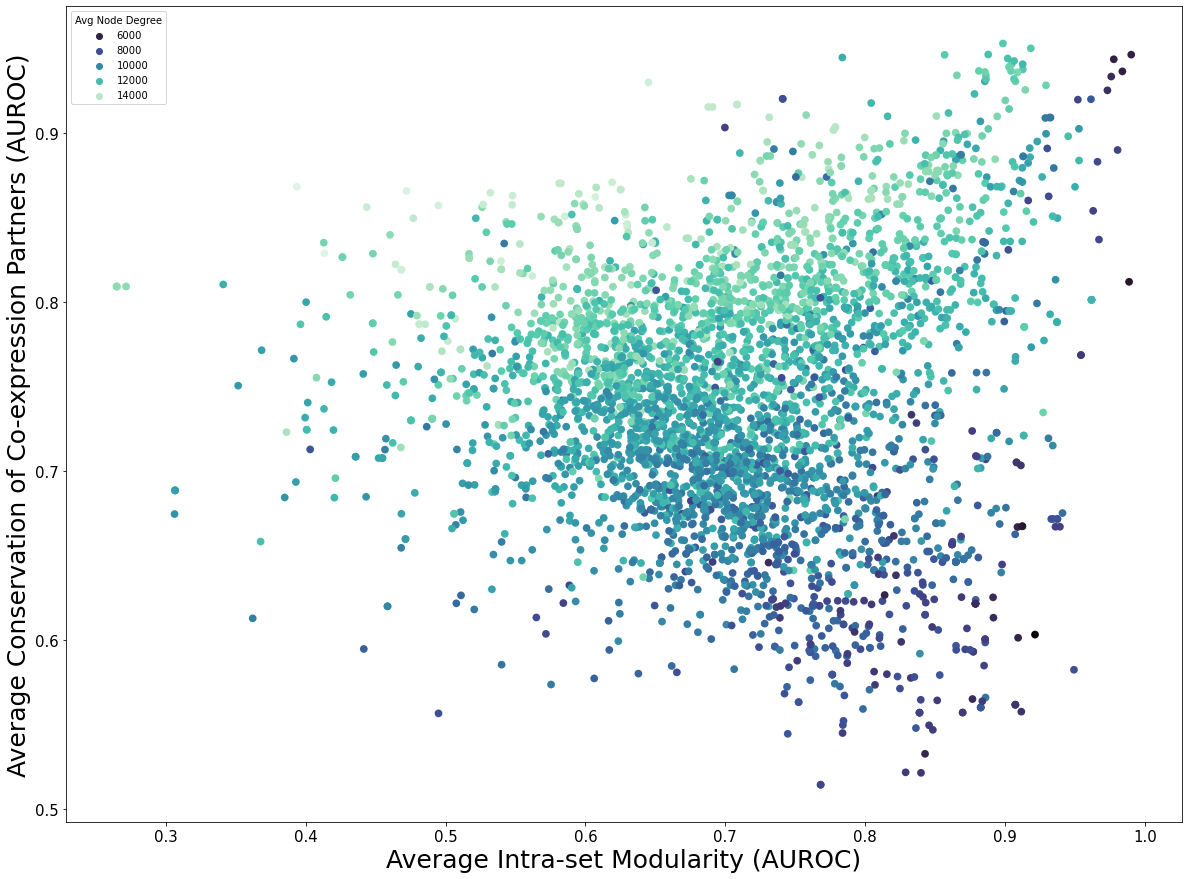

In [52]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = arabidopsis_all_group_data,y = 'Avg FC',x = 'Avg EGAD',s = 60,hue = "Avg Node Degree",edgecolor = 'none', palette = 'mako')

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)